# EfficientNet model validation

### Define EfficientNet structure

In [21]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np 

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):
        """
        Convolutional Layer kernel size Fi 
        Skip connection (shortcut) kernel size Ki 
        """
        super(BasicBlock, self).__init__()
        self.drop = drop 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out



def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.
    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    """
    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True) 

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class ResNet(nn.Module):
    def __init__(
            self, 
            block, 
            num_blocks, 
            conv_kernel_sizes=None, 
            shortcut_kernel_sizes=None,
            num_classes=10, 
            num_channels=32, 
            avg_pool_kernel_size=4, 
            drop=None, 
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        # self.avg_pool_kernel_size = avg_pool_kernel_size 
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))
        
        """
        # of channels Ci 
        """
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels) 

        self.drop = drop 
        self.squeeze_and_excitation = squeeze_and_excitation 

        if self.squeeze_and_excitation: 
            self.seblock = SEBlock(channels=self.num_channels) 

        """
        # of Residual Layers N 
        # of Residual Blocks Bi 
        """
        self.residual_layers = [] 
        for n in range(len(num_blocks)): 
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers 
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers 
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers 
            self.residual_layers.append(self._make_layer(
                                                    block, 
                                                    self.num_channels*(2**n), 
                                                    num_blocks[n], 
                                                    stride=stride, 
                                                    conv_kernel_size=conv_kernel_size, 
                                                    shortcut_kernel_size=shortcut_kernel_size)) 

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes) 
        """
        Dropout layer 
        """
        if self.drop: 
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out) 
        for layer in self.residual_layers: 
            out = layer(out)         
        """
        Average pool kernel size 
        """
        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out


def project1_model(config=None): 
    # Best Model 
    net =  ResNet(
            block=BasicBlock, 
            num_blocks=[4, 4, 3],                          # N: number of Residual Layers | Bi:Residual blocks in Residual Layer i 
            conv_kernel_sizes=[3, 3, 3],            # Fi: Conv. kernel size in Residual Layer i 
            shortcut_kernel_sizes=[1, 1, 1] ,    # Ki: Skip connection kernel size in Residual Layer i 
            num_channels=66,                      # Ci: # channels in Residual Layer i 
            avg_pool_kernel_size=8,      # P: Average pool kernel size 
            drop=0,                                      # use dropout with drop proportion 
            squeeze_and_excitation=1   # Enable/disable Squeeze-and-Excitation Block 
        ) 
    
    total_params = 0 
    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    return net, total_params 

### Load checkpoint

In [22]:
from collections import OrderedDict
import torch
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    print(checkpoint.keys())
    print(checkpoint['epoch'])
    print(checkpoint['acc'])
    print(checkpoint['config'])
    model, total_params = project1_model(config=checkpoint['config'])
    state_dict = checkpoint['net']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./best_model/ckpt.pth')


# print(model.accuracy())
# print(model)

dict_keys(['net', 'acc', 'epoch', 'config'])
199
95.65
{'conv_kernel_sizes': [3, 3, 3], 'num_blocks': [4, 4, 3], 'num_channels': 66, 'shortcut_kernel_sizes': [1, 1, 1], 'avg_pool_kernel_size': 8, 'drop': 0.1, 'squeeze_and_excitation': 1, 'max_epochs': 250, 'optim': 'sgd', 'lr_sched': 'CosineAnnealingLR', 'momentum': 0.9, 'lr': 0.1, 'weight_decay': 0.0005, 'batch_size': 256, 'num_workers': 8, 'resume_ckpt': 0, 'data_augmentation': 1, 'data_normalize': 1, 'grad_clip': 0.1, 'lookahead': 1, 'total_params': 4995554}


In [23]:
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

4995554


<img src="https://raw.githubusercontent.com/Naman36/resnet-mini-project/c27f303728f5176d29b7f4f5a4652f0fa9278b6d/accuracies.png" style="height:300px" />

<img src="https://raw.githubusercontent.com/Naman36/resnet-mini-project/c27f303728f5176d29b7f4f5a4652f0fa9278b6d/losses.png" style="height:300px" />

### Load test data

In [24]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('./data/cifar_test_nolabels.pkl')
comp_test_data = data[b'data']
ids = data[b'ids']

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class CustomDataset(Dataset):
    def __init__(self, data_lists, transform=None):
        """
        data_lists: List of lists, where each sublist is 3072 elements representing an image.
        transform: PyTorch transforms to apply to the data.
        """
        self.data_lists = data_lists
        self.transform = transform

    def __len__(self):
        return len(self.data_lists)

    def __getitem__(self, idx):
        # Convert list to tensor and reshape to 3x32x32
        image = torch.FloatTensor(self.data_lists[idx]).view(3, 32, 32) / 255.0
        if self.transform:
            image = self.transform(image)
        return image

# Define the transform including normalization
transform_test = transforms.Compose([
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = CustomDataset(comp_test_data, transform=transform_test)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Assuming 'model' is your trained model
model.eval()  # Set the model to evaluation mode

predictions = []
with torch.no_grad():
    for images in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

In [26]:
print(predictions[:100])

[8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


### Output CSV file with predictions

In [27]:
import csv

# Assuming 'ids' is your list of IDs in the same order as 'your_data_lists'
# And 'predictions' is the list of labels you obtained from the model

# Specify your output CSV file name
output_csv_file = 'newnew.csv'

# Writing to the CSV file
with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['ID', 'Label'])
    # Write the ID and Label pairs
    for id, label in zip(ids, predictions):
        writer.writerow([id, label])

print(f"CSV file '{output_csv_file}' has been created with ID and Label columns.")


CSV file 'newnew.csv' has been created with ID and Label columns.


(10000, 3072)
cat


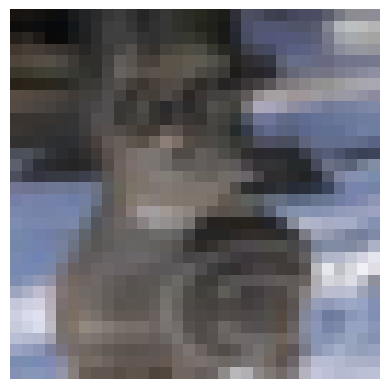

deer


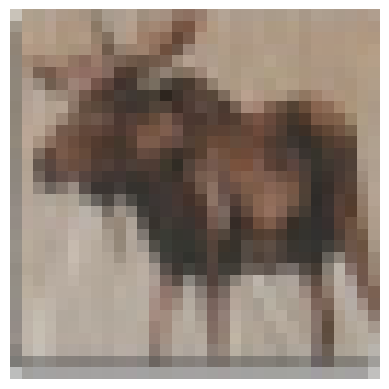

deer


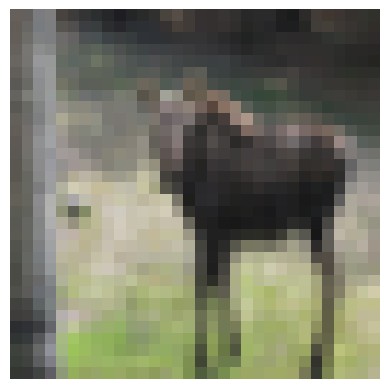

deer


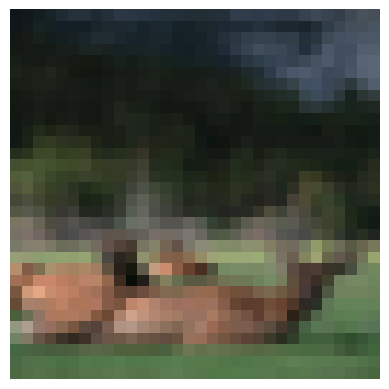

deer


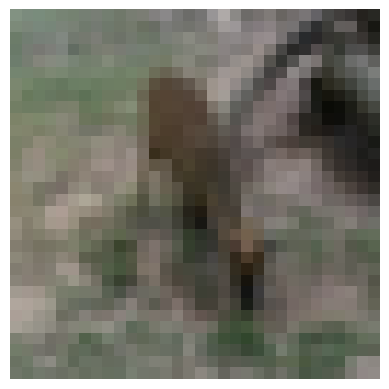

deer


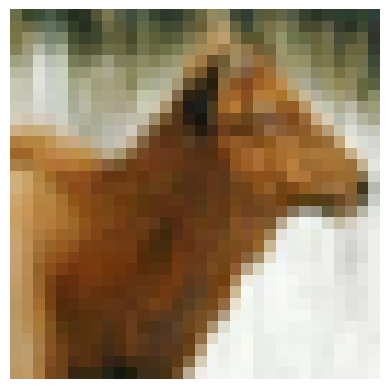

deer


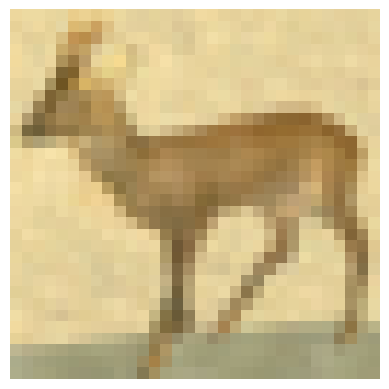

deer


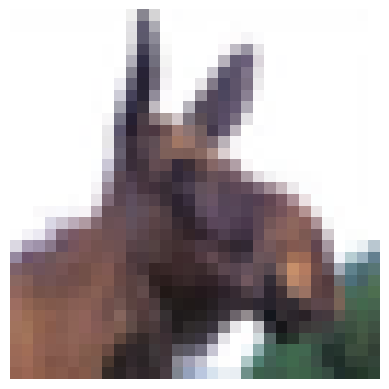

deer


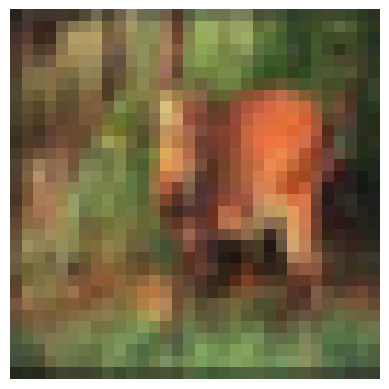

deer


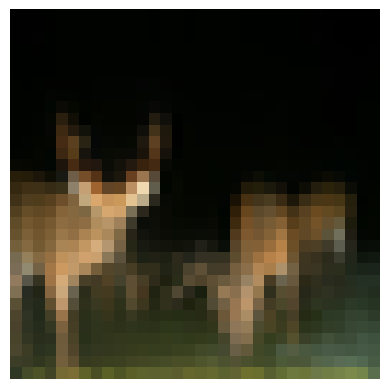

deer


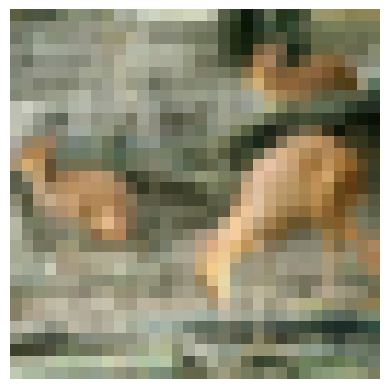

deer


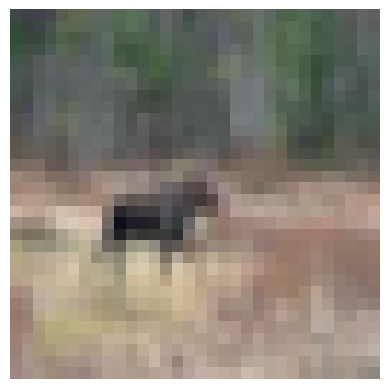

deer


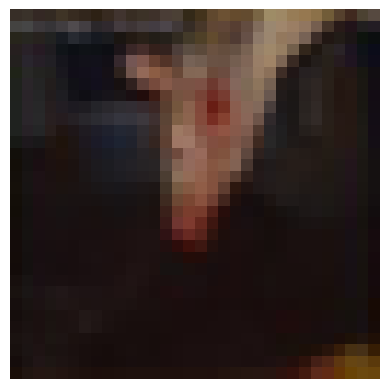

deer


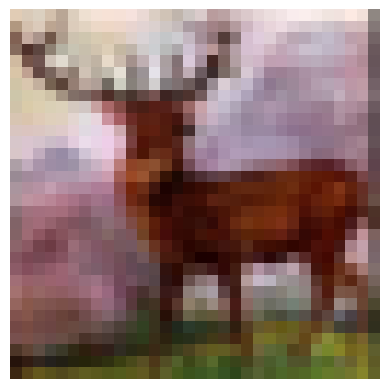

frog


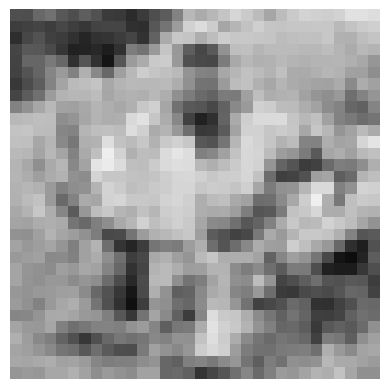

deer


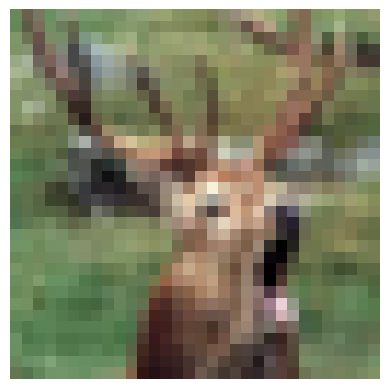

deer


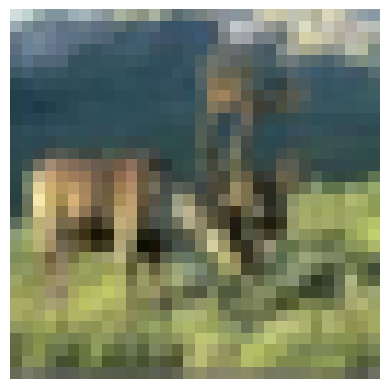

deer


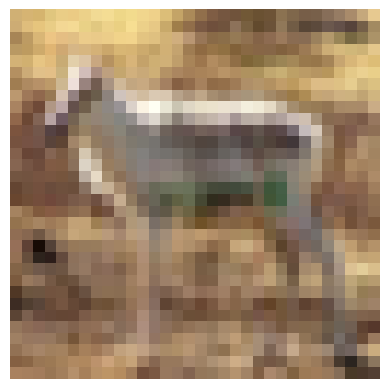

deer


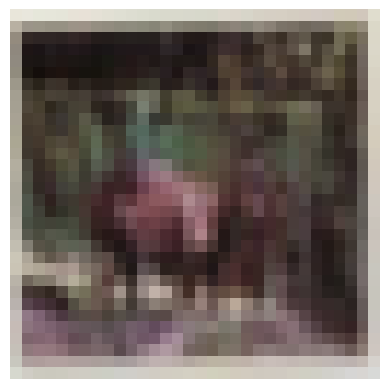

deer


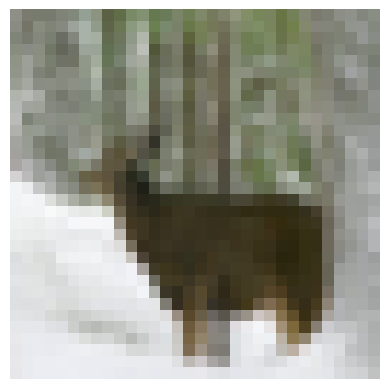

In [28]:
import matplotlib.pyplot as plt
print(comp_test_data.shape)
for i in range(4580,4600):
    image = comp_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0)
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    print(classes[predictions[i]])
    # Visualize the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

### Plots of training data to analyze data augmentation configuration

Files already downloaded and verified
cat


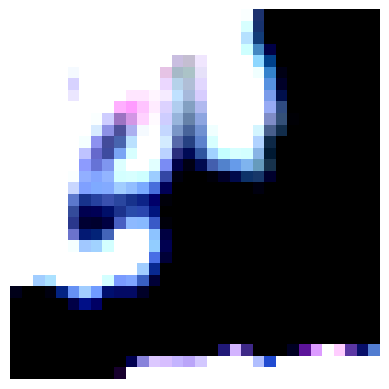

bird


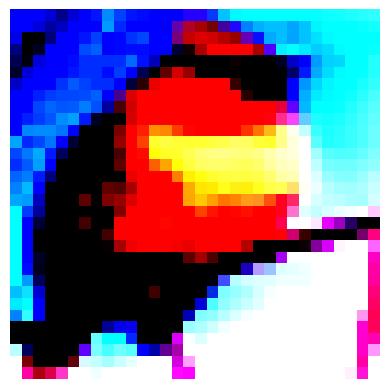

plane


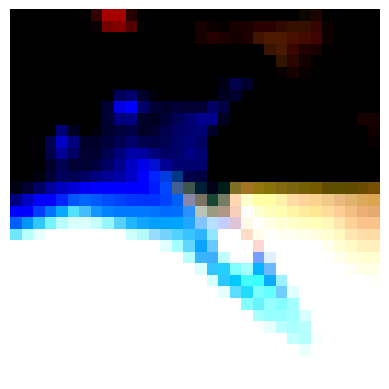

ship


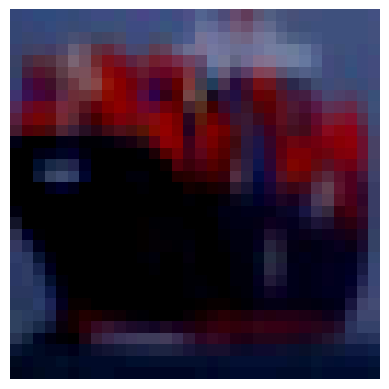

car


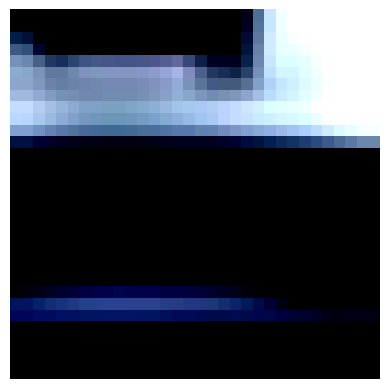

horse


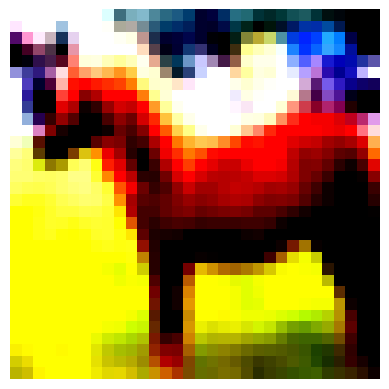

truck


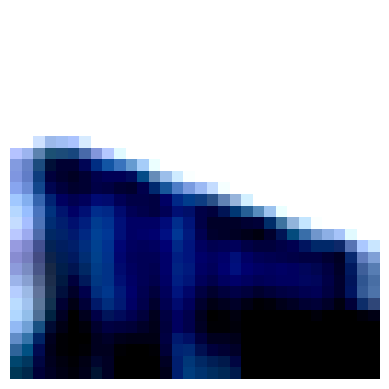

horse


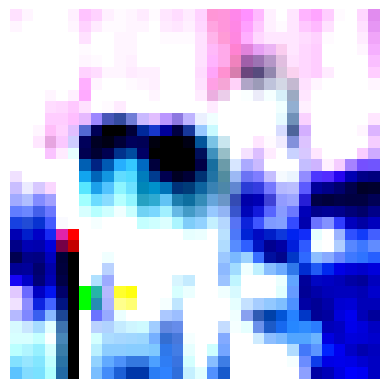

bird


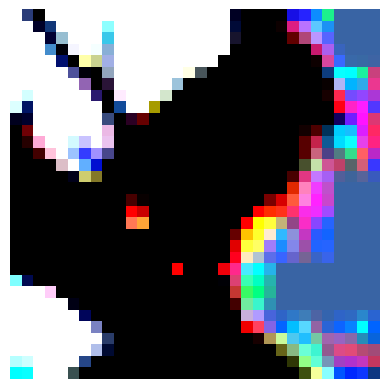

plane


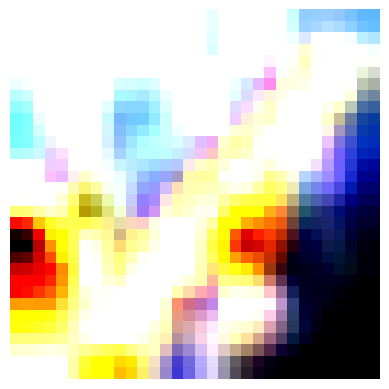

deer


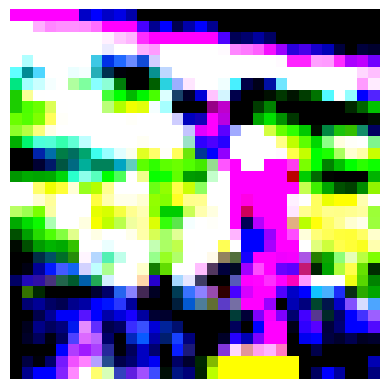

frog


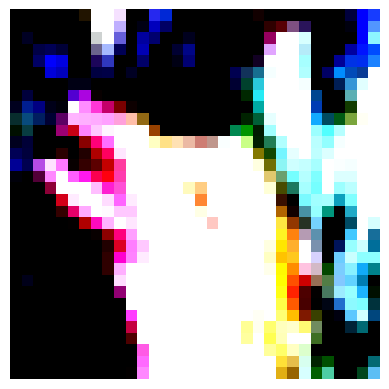

ship


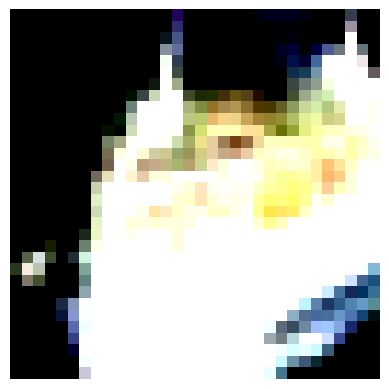

car


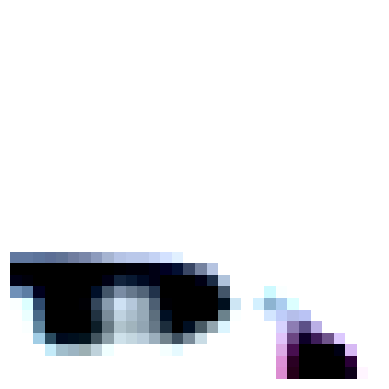

dog


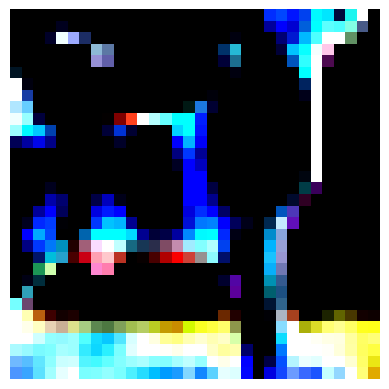

horse


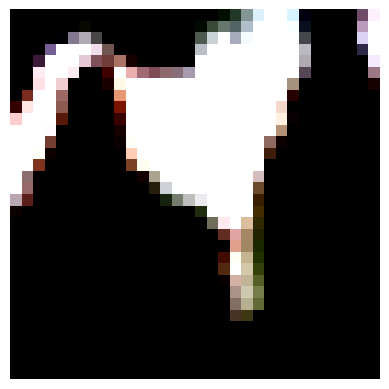

truck


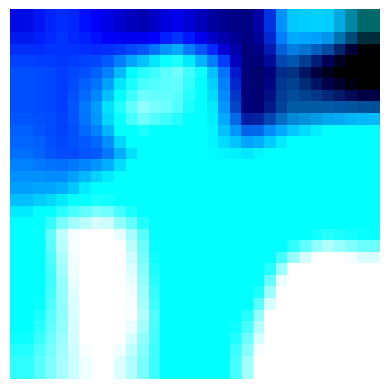

horse


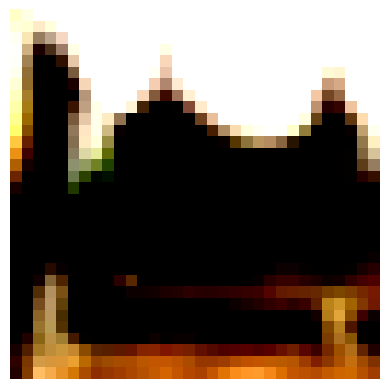

plane


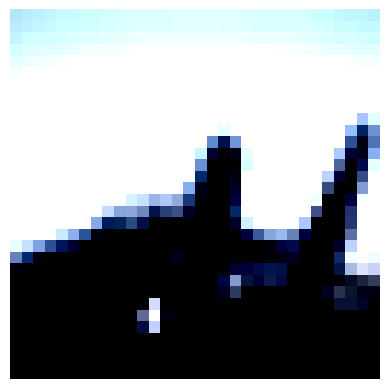

deer


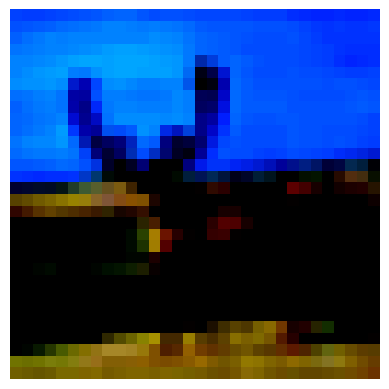

In [29]:
transform_train = transforms.Compose([
    transforms.AutoAugment(),
    transforms.RandomResizedCrop(32, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),  # Move this before Normalize
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
import matplotlib.pyplot as plt
for i in range(8880,8900):

    
    trainset_label = trainset[i][1]
    image = trainset[i][0].permute(1, 2, 0)
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    print(classes[trainset_label]);
    # Visualize the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [30]:
trainset_label = trainset[1][1]
print(classes[trainset_label])

truck
